In [1]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL as pil
import os
import PIL
import pathlib
import glob
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.utils import shuffle

#Set to GPU
devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(devices[0], True)

#Path
images_source = pathlib.Path("D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data")

#Input images
input_dir = images_source / "ISIC2018_Task1-2_Training_Input_x2\*.jpg"

#Segmentation images (label images)
seg_dir = images_source / "ISIC2018_Task1_Training_GroundTruth_x2\*.png"
                             
#Setup arrays for training, testing and validation datasets
X_train = None
X_test = None
X_valid = None
y_train = None
y_test = None
y_valid = None

training = None
validation = None
testing = None

In [2]:
print(input_dir)
print(seg_dir)

D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data\ISIC2018_Task1-2_Training_Input_x2\*.jpg
D:\s4532664\COMP3710\ISIC2018_Task1-2_Training_Data\ISIC2018_Task1_Training_GroundTruth_x2\*.png


In [3]:
"""
The following function will convert a passed-in filename to an image.
Processing, such as resizing, normalising (0 to 1) and casting (divide by 255) are done to it to be used in the model.

Parameters:
    input_file: File name of the input image (scan)
    seg_file: File name of the segmentation image (label image)

Returns:
    Tuple containing 2 tensors of the input image and segmentation image, after processing has been completed
"""
def convert_file_image(input_file, seg_file):
   
    input_image = tf.io.read_file(input_file)
    input_image = tf.image.decode_jpeg(input_image, channels = 1)
    input_image = tf.image.resize(input_image, [256, 256])
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    seg_image = tf.io.read_file(seg_file)
    seg_image = tf.image.decode_png(seg_image, channels = 1)
    seg_image = tf.image.resize(seg_image, [256, 256])
    seg_image = seg_image == [0, 255]
    
    return input_image, seg_image

In [4]:
"""
The following function creates TF datasets for training, testing and validation purposes, based on the data passed in.
The data will be split into the following: 3 datasets (Training - 50%, Validation - 25%, Testing - 25%)
The data will also be shuffled, before being split to allow for images of varying difficult to be potentially considered.

Parameters:
    inputdir: Path of directory that has the input images (scan)
    segdir: Path of directory that has the segmentation images (label)

Returns:
    Tuple containing 3 tensors of the training, validaton and testing datasets.
    Each of those datasets has both the input image and segmentation images.
"""
def load_data(inputdir, segdir):
    
    xtrain = sorted(glob.glob(str(inputdir)))
    ytrain = sorted(glob.glob(str(segdir)))
    
    #Shuffle the data
    xtrain, ytrain = shuffle(xtrain, ytrain)
    
    #Split the images into 3 datasets (Training - 50%, Validation - 25%, Testing - 25%)
    half_length = int(len(xtrain)/2)
    quarter_length_ceil = int(tf.math.ceil(len(xtrain)/4))
    
    global X_test, X_valid, X_train, y_test, y_valid, y_train
        
    X_test = xtrain[-(quarter_length_ceil-1):]
    X_valid = xtrain[half_length:half_length + quarter_length_ceil]
    X_train = xtrain[0:half_length]
    
    y_test = ytrain[-(quarter_length_ceil-1):]
    y_valid = ytrain[half_length:half_length + quarter_length_ceil]
    y_train = ytrain[0:half_length]
    
    #Create datasets
    traindata = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    validdata = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    testdata = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    #Process every filename and convert to image
    traindata = traindata.map(convert_file_image)
    validdata = validdata.map(convert_file_image)
    testdata = testdata.map(convert_file_image)
    
    return traindata, validdata, testdata

In [5]:
#Run the function of loading data into each dataset
training, validation, testing = load_data(input_dir, seg_dir)

In [6]:
"""
The following function will determine the Dice coefficient, which is a spatial overlap index.
This measures the overlap between 2 samples and will be used as the metric to determine the performance of the model.
The link "https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2" by Ekin Tu (2019)
assisted with the understanding of the Dice coefficient and the code behind it.

Parameters:
    y_actual: Actual segmentation image (Ground truth)
    y_predicted: Predicted segmentation image (label)

Returns:
    Dice coefficient
"""
def dice_coefficient(y_actual, y_predicted):
    y_actual = tf.keras.backend.flatten(y_actual)
    y_predicted = tf.keras.backend.flatten(y_predicted)
    intersection_y = tf.keras.backend.sum(y_actual * y_predicted)
    union_y = tf.keras.backend.sum(y_actual) + tf.keras.backend.sum(y_predicted)
    return ((2.0*intersection_y + 1e-7) / (union_y + 1e-7))

"""
The following function will determine the Dice distance.
This value will show how much of the predicted segmentation image fails to match the actual image.

Parameters:
    y_actual: Actual segmentation image (Ground truth)
    y_predicted: Predicted segmentation image (label)

Returns:
    Dice loss
"""
def dice_loss(y_actual, y_predicted):
    return 1 - dice_coefficient(y_actual, y_predicted)

In [7]:
"""
Context module for the Improved U-Net model, for the encoder phase.
Contains a pre-activation residual block with 2 3x3x3 convolutional layers
and a dropout layer in between (refer to the README file for more information).

Parameters:
    layer: The tensor that is passed in for the context module to be continued on.
    filter_size: Numebr of convolution filters

Returns:
    layer: The tensor, after the context module has been completed on it
"""
def context_module_unet(layer, filter_size):
    layer = BatchNormalization()(layer)
    layer = Conv2D(filter_size, (3, 3), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.3)(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv2D(filter_size, (3, 3), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.3)(layer)

    return layer

"""
Upsampling module for the Improved U-Net model, for the decoder phase.
Contains a up-sampling layer, followed by a 3x3x3 convolution layer halving the number of feature maps
(refer to the README file for more information).

Parameters:
    layer: The tensor that is passed in for the context module to be continued on.
    filter_size: Numebr of convolution filters

Returns:
    layer: The tensor, after the upsampling module has been completed on it
"""
def upsample_module_unet(layer, filter_size):
    layer = UpSampling2D()(layer)
    layer = Conv2D(filter_size, (3, 3), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.3)(layer)
    
    return layer
    
"""
Localisation module for the Improved U-Net model, for the decoder phase.
Used to transfer information that have been encoded by lower levels to higher spatial resolutions.
Contains a 3x3x3 convolution layer, followed by a 1x1x1 one
(refer to the README file for more information).

Parameters:
    layer: The tensor that is passed in for the context module to be continued on.
    filter_size: Numebr of convolution filters

Returns:
    layer: The tensor, after the upsampling module has been completed on it
"""
def localisation_module_unet(layer, filter_size):
    layer = Conv2D(filter_size, (3, 3), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.3)(layer)
    layer = Conv2D(filter_size, (1, 1), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.3)(layer)

    return layer

"""
Segmentation layer module for the Improved U-Net model, for the decoder phase.
Used for deep supervision in the localisation module
(refer to the README file for more information).

Parameters:
    localise_module_a: Second localisation module run in the U-Net
    localise_module_b: Third localisation module run in the U-Net
    conv_a: Second-last convolutional layer run in the U-Net

Returns:
    sum_b: An element-wise summation of the combined
"""
def segmentation_layer(localise_module_a, localise_module_b, conv_a):
    segment_1 = Conv2D(1, (1, 1), padding = 'same')(localise_module_a)
    segment_1 = LeakyReLU(alpha = 0.3)(segment_1)

    upsample_a = UpSampling2D()(segment_1)
    
    segment_2 = Conv2D(1, (1, 1), padding = 'same')(localise_module_b)
    segment_2 = LeakyReLU(alpha = 0.3)(segment_2)
    sum_a = add([upsample_a, segment_2])
    
    upsample_b = UpSampling2D()(sum_a)
    segment_3 = Conv2D(1, (1, 1), padding = 'same')(conv_a)
    segment_3 = LeakyReLU(alpha = 0.3)(segment_3)

    sum_b = add([upsample_b, segment_3])
    
    return sum_b

In [8]:
def unet_model():
    inputs = Input((256, 256, 1))
    
    conv2D_1 = Conv2D(8, (3, 3), padding = 'same')(inputs)
    conv2D_1 = LeakyReLU(alpha = 0.3)(conv2D_1)
    
    cont_1 = context_module_unet(conv2D_1, 8)
    sum_1 = add([conv2D_1, cont_1])
    
    conv2D_2 = Conv2D(16, (3, 3), padding = 'same', strides = 2)(sum_1)
    conv2D_2 = LeakyReLU(alpha = 0.3)(conv2D_2)
    cont_2 = context_module_unet(conv2D_2, 16)
    sum_2 = add([conv2D_2, cont_2])
    
    conv2D_3 = Conv2D(32, (3, 3), padding = 'same', strides = 2)(sum_2)
    conv2D_3 = LeakyReLU(alpha = 0.3)(conv2D_3)
    cont_3 = context_module_unet(conv2D_3, 32)
    sum_3 = add([conv2D_3, cont_3])
    
    conv2D_4 = Conv2D(64, (3, 3), padding = 'same', strides = 2)(sum_3)
    conv2D_4 = LeakyReLU(alpha = 0.3)(conv2D_4)
    cont_4 = context_module_unet(conv2D_4, 64)
    sum_4 = add([conv2D_4, cont_4])
    
    conv2D_5 = Conv2D(128, (3, 3), padding = 'same', strides = 2)(sum_4)
    conv2D_5 = LeakyReLU(alpha = 0.3)(conv2D_5)
    cont_5 = context_module_unet(conv2D_5, 128)
    sum_5 = add([conv2D_5, cont_5])
    
    upsample_1 = upsample_module_unet(sum_5, 64)
    concatenate_1 = concatenate([upsample_1, sum_4])
    
    localise_1 = localisation_module_unet(concatenate_1, 64)
    upsample_2 = upsample_module_unet(localise_1, 32)
    concatenate_2 = concatenate([upsample_2, sum_3])
    
    localise_2 = localisation_module_unet(concatenate_2, 32)
    upsample_3 = upsample_module_unet(localise_2, 16)
    concatenate_3 = concatenate([upsample_3, sum_2])
    
    localise_3 = localisation_module_unet(concatenate_3, 16)
    upsample_4 = upsample_module_unet(localise_3, 8)
    concatenate_4 = concatenate([upsample_4, sum_1])
    
    conv2D_6 = Conv2D(16, (3, 3), padding = 'same')(concatenate_4)
    conv2D_6 = LeakyReLU(alpha = 0.3)(conv2D_6)
    
    segmentation_1 = segmentation_layer(localise_2, localise_3, conv2D_6)
    
    conv2D_final = Conv2D(2, (1, 1), activation = 'sigmoid', padding = 'same')(segmentation_1)

    model = tf.keras.Model(inputs=inputs, outputs=conv2D_final)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])

    return model

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [9]:
model = unet_model()
results = model.fit(x=training.batch(10), epochs = 30, validation_data = validation.batch(10))

Train for 130 steps, validate for 65 steps
Epoch 1/30
130/130 [==============================] - 71s 549ms/step - loss: 0.5391 - dice_coefficient: 0.6755 - val_loss: 0.5686 - val_dice_coefficient: 0.6406
Epoch 2/30
130/130 [==============================] - 47s 361ms/step - loss: 0.4339 - dice_coefficient: 0.7448 - val_loss: 0.4373 - val_dice_coefficient: 0.7055
Epoch 3/30
130/130 [==============================] - 57s 437ms/step - loss: 0.3298 - dice_coefficient: 0.8124 - val_loss: 0.3182 - val_dice_coefficient: 0.8175
Epoch 4/30
130/130 [==============================] - 27s 206ms/step - loss: 0.2697 - dice_coefficient: 0.8456 - val_loss: 0.2714 - val_dice_coefficient: 0.8508
Epoch 5/30
130/130 [==============================] - 57s 436ms/step - loss: 0.2403 - dice_coefficient: 0.8616 - val_loss: 0.2286 - val_dice_coefficient: 0.8720
Epoch 6/30
130/130 [==============================] - 77s 590ms/step - loss: 0.2131 - dice_coefficient: 0.8771 - val_loss: 0.2053 - val_dice_coefficient

65/65 [==============================] - 19s 294ms/step - loss: 0.2316 - dice_coefficient: 0.9203


The DSC on the testing dataset:  0.92029727
The loss on the testing dataset:  0.23157183327353917


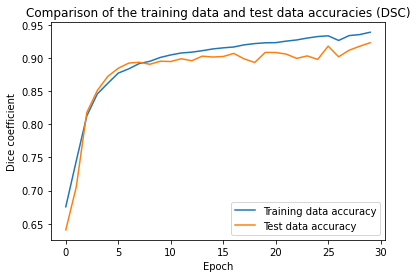

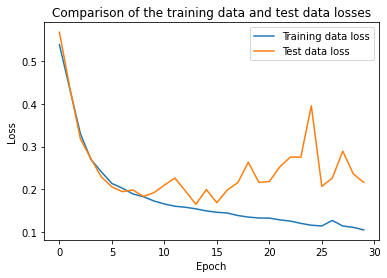

In [19]:
plt.plot(results.history['dice_coefficient'], label='Training data accuracy')
plt.plot(results.history['val_dice_coefficient'], label = 'Test data accuracy')
plt.title('Comparison of the training data and test data accuracies (DSC)')
plt.xlabel('Epoch')
plt.ylabel('Dice coefficient')
plt.legend(loc='lower right')

plt.figure()
plt.plot(results.history['loss'], label='Training data loss')
plt.plot(results.history['val_loss'], label = 'Test data loss')
plt.title('Comparison of the training data and test data losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x=testing.batch(10))
print("\n")
print("The DSC on the testing dataset: ", test_acc)
print("The loss on the testing dataset: ", test_loss)


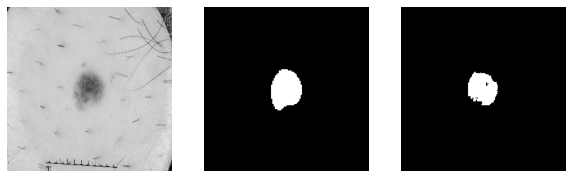

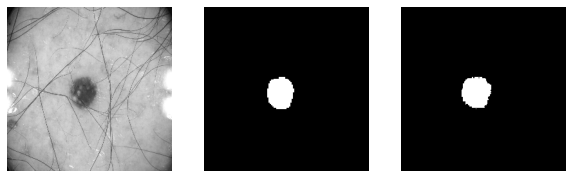

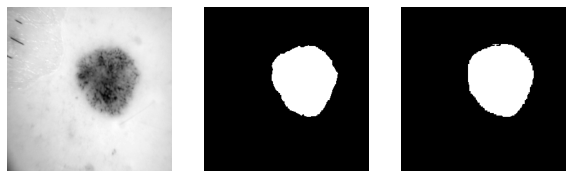

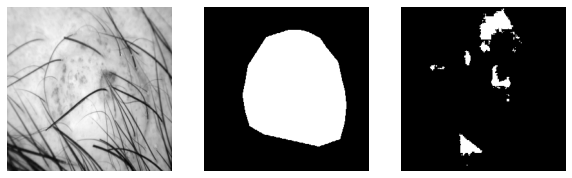

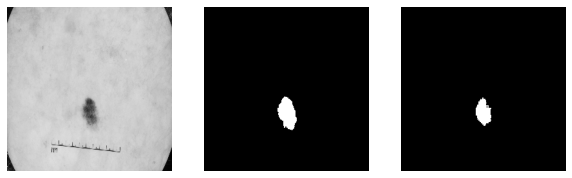

In [29]:
for image, mask in testing.take(5):
    pred_mask = model.predict(image[tf.newaxis,...])
    pred_mask = tf.argmax(pred_mask[0],axis=-1)
    plt.figure(figsize=(10,10))
    
    mask = tf.cast(mask, tf.float32)

    
    disp_list = [tf.squeeze(image), tf.argmax(mask, axis=-1), pred_mask]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(disp_list[i], cmap = "gray")
        plt.axis('off')
    plt.show()
